In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,auc,roc_auc_score,precision_score,recall_score

Using TensorFlow backend.


In [3]:
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
import os

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import random

import datetime
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

cwd = os.getcwd()
print(cwd)

#Change working directory
os.chdir(r'''C:\Users\wscott\Python_Stuff''')
print(cwd)


C:\Users\wscott\Python_Stuff\Thinkful_Drills
C:\Users\wscott\Python_Stuff\Thinkful_Drills


First let's open up the stroke file

In [4]:
df = pd.read_csv("train_2v.csv")

In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [9]:
df.isnull().sum()/len(df)*100

id                    0.000000
gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   3.368664
smoking_status       30.626728
stroke                0.000000
dtype: float64

As you can see, BMI has roughly 3% empty fields. There are a few ways to deal with this, number one being deleting these entries entirely and the other being imputing. We could choose to impute with the mean, synthetic imputation using SMOTE, or a linear regressor based on other fields. We will will impute using the mean, but it is important to know the other techniques at our disposal.

In [10]:
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())

Now smoking_status has a significant portion of data missing, roughly 31%. Its not recommended to impute this much data, so we're going to create a dataset with smoking_status data and without it. But first, let's encode the categorical variables so we don't have to do it twice for the 2 newly created datasets.

In [11]:
label = LabelEncoder()
df['gender'] = label.fit_transform(df['gender'])
df['ever_married'] = label.fit_transform(df['ever_married'])
df['work_type']= label.fit_transform(df['work_type'])
df['Residence_type']= label.fit_transform(df['Residence_type'])

In [12]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,0,4,0,95.12,18.0,NaN,0
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,never smoked,0
2,16523,0,8.0,0,0,0,2,1,110.89,17.6,NaN,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,formerly smoked,0
4,46136,1,14.0,0,0,0,1,0,161.28,19.1,NaN,0


In [13]:
df_without_smoke_data = df[df['smoking_status'].isnull()]
df_with_smoke_data = df[df['smoking_status'].notnull()]

#Enoding the smoking_status data as well
df_with_smoke_data['smoking_status']= label.fit_transform(df_with_smoke_data['smoking_status'])

c:\users\wscott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Now let's take a look at correlation among the variables. If we see heavy correlation, we may consider removing one of the columns or running PCA to reduce redundant variables

                         id    gender       age  hypertension  heart_disease  \
id                 1.000000  0.005445  0.000131      0.002157       0.013075   
gender             0.005445  1.000000  0.040785      0.037431       0.097549   
age                0.000131  0.040785  1.000000      0.259528       0.251819   
hypertension       0.002157  0.037431  0.259528      1.000000       0.114957   
heart_disease      0.013075  0.097549  0.251819      0.114957       1.000000   
ever_married       0.000043  0.024852  0.546996      0.133258       0.098229   
work_type          0.008955  0.010247  0.018850      0.019309       0.034466   
Residence_type    -0.000966  0.004814  0.004044     -0.004427      -0.000583   
avg_glucose_level  0.020976  0.053496  0.230682      0.154702       0.139449   
bmi                0.013226  0.019278  0.101619      0.120730       0.018562   
smoking_status     0.004082 -0.013613 -0.147968     -0.030094      -0.035660   
stroke             0.002238  0.013689  0

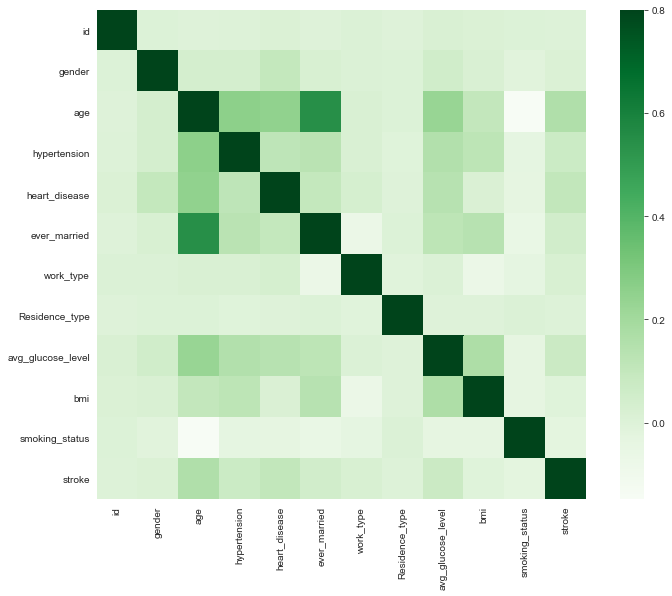

In [14]:
# Make the correlation matrix.
corrmat = df_with_smoke_data.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap='Greens')
plt.show()

Most of the variables seem to be uncorrelated. The highest correlation seems to be between age and ever_married, which we can take into account as we select features for our final model.

In addition, let's remove the id column as the model should not be trained on a randomly generated identification number.

In [15]:
df_without_smoke_data = df_without_smoke_data.loc[:,df_without_smoke_data.columns!='smoking_status']

df_with_smoke_data = df_with_smoke_data.loc[:,df_with_smoke_data.columns!='id']
df_without_smoke_data = df_without_smoke_data.loc[:,df_without_smoke_data.columns!='id']

Now, let's take a look at how well the targeted variable is balanced in the dataset.

In [16]:
df_with_smoke_data['stroke'].value_counts()

0    29470
1      638
Name: stroke, dtype: int64

In [17]:
df_without_smoke_data['stroke'].value_counts()

0    13147
1      145
Name: stroke, dtype: int64

Because the dataset is severely unbalanced, we will need use the Random Over Sampler to over-sample the minority class. This will allow the model to detect subtle nuances in both classes to improve accuracy. 

Note: We could also use Random Under Sampler to reduce the majority class or SMOTE to add synthetic data to the minority class.

In [18]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
smote = SMOTE()

We're going to be dealing with multiple datasets and models with varying features as we look to optimize and simplify. Let's begin by creating a function.

Note: We are using the Random Over Sampler within the function.

In [81]:
#Taking in the dataset in addition to adding a label to differentiate the models

def build_model(model, data, label):

    #Using Random Over Sampler to alleviate the class imbalance
    X, y = ros.fit_resample(data.loc[:,data.columns!='stroke'], data['stroke'])
    
    
    
    print('Model: ' + label)

    #Split the testing and training data
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    print('\nTraining Shape: ')
    print(X_train.shape)
    print('\nTest Shape: ')
    print(X_test.shape)

    
    #Initialize and fit the Random Forest Classifier
    #ran = RandomForestClassifier(n_estimators=50,random_state=0)
    #ran.fit(X_train,y_train)
    model.fit(X_train,y_train)

    print('\nClassification Report: \n')

    #Setting up the classification report to determine performance
    pred = model.predict(X_test)
    print(classification_report(y_test,pred))
    print('\nConfusion Matrix: \n')
    print (confusion_matrix(y_test,pred))

    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print( '\nprecision = ', precision, '\nrecall = ', recall, '\naccuracy = ', accuracy)

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)

    plt.title(label)
    plt.show()

    #Logistic regression calls for a different format to extract feature importances
    if "Logistic" in mlbl:
    
        impFeatures = pd.DataFrame(model.coef_[0] ,index=data.loc[:,data.columns!='stroke'].columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
        print (impFeatures)
    
    else:
    
        print('\nFeature Importance\n')
        impFeatures = pd.DataFrame((model.feature_importances_) ,index=data.loc[:,data.columns!='stroke'].columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
        print (impFeatures)

    #Return the function to be placed in the dictionary
    return model

To manage the multiple datasets, we're going to organize them in a dictionary with the title of the dataset and later add in the model as another item. 

In [82]:
#Various models to be tested
dtree = DecisionTreeClassifier()
log = LogisticRegression(penalty='l2', C=0.1)
ran = RandomForestClassifier(n_estimators=50,random_state=0)

model_repo = {}

Model: Decision Tree with smoking data

Training Shape: 
(47152, 10)

Test Shape: 
(11788, 10)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5923
           1       0.98      1.00      0.99      5865

    accuracy                           0.99     11788
   macro avg       0.99      0.99      0.99     11788
weighted avg       0.99      0.99      0.99     11788


Confusion Matrix: 

[[5785  138]
 [   0 5865]]

precision =  0.9770114942528736 
recall =  1.0 
accuracy =  0.988293179504581


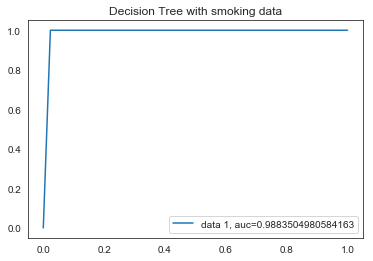


Feature Importance

                   Importance
age                  0.391418
avg_glucose_level    0.255820
bmi                  0.206482
smoking_status       0.038207
work_type            0.032696
Residence_type       0.021174
gender               0.017082
heart_disease        0.016599
hypertension         0.013326
ever_married         0.007195


In [83]:
#Creating a label for our first entry in the dictionary
mlbl = 'Decision Tree with smoking data'

#Setting the trained model to its corresponding label
model_repo[mlbl] = build_model(dtree, df_with_smoke_data, mlbl)

Model: Logistic Regression with smoking data

Training Shape: 
(47152, 10)

Test Shape: 
(11788, 10)


c:\users\wscott\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Classification Report: 

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5880
           1       0.75      0.79      0.77      5908

    accuracy                           0.76     11788
   macro avg       0.76      0.76      0.76     11788
weighted avg       0.76      0.76      0.76     11788


Confusion Matrix: 

[[4312 1568]
 [1269 4639]]

precision =  0.7473819880779765 
recall =  0.7852064996614759 
accuracy =  0.759331523583305


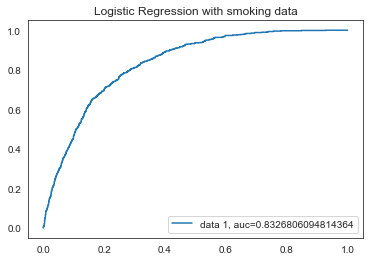

                   Importance
heart_disease        0.704840
hypertension         0.433948
Residence_type       0.093518
age                  0.071963
gender               0.057896
smoking_status       0.057453
work_type            0.023083
avg_glucose_level    0.003805
bmi                 -0.010952
ever_married        -0.045108


In [84]:
#Creating a label for our first entry in the dictionary
mlbl = 'Logistic Regression with smoking data'

#Setting the trained model to its corresponding label
model_repo[mlbl] = build_model(log, df_with_smoke_data, mlbl)

Model: Random Forest with smoking data

Training Shape: 
(47152, 10)

Test Shape: 
(11788, 10)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5856
           1       1.00      1.00      1.00      5932

    accuracy                           1.00     11788
   macro avg       1.00      1.00      1.00     11788
weighted avg       1.00      1.00      1.00     11788


Confusion Matrix: 

[[5839   17]
 [   0 5932]]

precision =  0.9971423768700622 
recall =  1.0 
accuracy =  0.9985578554462164


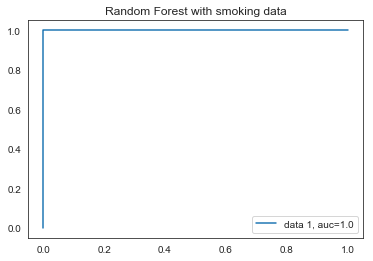


Feature Importance

                   Importance
age                  0.367883
avg_glucose_level    0.229504
bmi                  0.198122
smoking_status       0.040965
work_type            0.037320
heart_disease        0.031419
hypertension         0.026038
Residence_type       0.025288
gender               0.022745
ever_married         0.020716


In [85]:
#Creating a label for our first entry in the dictionary
mlbl = 'Random Forest with smoking data'

#Setting the trained model to its corresponding label
model_repo[mlbl] = build_model(ran, df_with_smoke_data, mlbl)

With the highest performance seen in our Random Forest Classifier in terms of precision, recall and accuracy, let's proceed with this model.

As you can see, our Random Forest Classifier precision was 99.7%. In addition, it managed to have 0 Type II errors, which is crucial when trying to identify something as important as categorizing someone with higher likelihood of stroke.

Now let's take a look at our dataset without the smoking_status column.

Model: Random Forest Classifier without smoke data

Training Shape: 
(21035, 9)

Test Shape: 
(5259, 9)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2635
           1       1.00      1.00      1.00      2624

    accuracy                           1.00      5259
   macro avg       1.00      1.00      1.00      5259
weighted avg       1.00      1.00      1.00      5259


Confusion Matrix: 

[[2629    6]
 [   0 2624]]

precision =  0.9977186311787072 
recall =  1.0 
accuracy =  0.9988590986879635


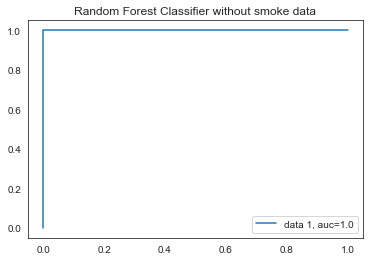


Feature Importance

                   Importance
age                  0.371993
bmi                  0.205307
avg_glucose_level    0.151866
ever_married         0.115234
work_type            0.078339
heart_disease        0.023428
gender               0.021125
Residence_type       0.019740
hypertension         0.012968


In [86]:
mlbl = 'Random Forest Classifier without smoke data'

model_repo[mlbl] = build_model(ran, df_without_smoke_data, mlbl)

Yet again, we are seeing our model have high precision and accuracy. With the creation of this second model, we notice that Residence_type and gender seem to have low importance in both models. I hypothesise that removing these columns will have little affect on model performance, so let's test that theory.

Model: Random Forest Classifier with smoke data minus gender and Residence_type

Training Shape: 
(47152, 7)

Test Shape: 
(11788, 7)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5868
           1       1.00      1.00      1.00      5920

    accuracy                           1.00     11788
   macro avg       1.00      1.00      1.00     11788
weighted avg       1.00      1.00      1.00     11788


Confusion Matrix: 

[[5839   29]
 [   0 5920]]

precision =  0.9951252311312826 
recall =  1.0 
accuracy =  0.9975398710553105


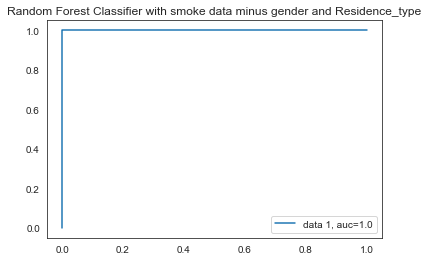


Feature Importance

                   Importance
age                  0.370361
avg_glucose_level    0.272161
bmi                  0.236272
heart_disease        0.036065
smoking_status       0.033000
hypertension         0.028996
ever_married         0.023144


In [87]:
mlbl = 'Random Forest Classifier with smoke data minus gender and Residence_type'

df_with_smoke_data_cols_removed_v1 = df_with_smoke_data[[ 'age', 'ever_married', 'hypertension', 'heart_disease', 'smoking_status',
                                                      'bmi', 'avg_glucose_level' , 'stroke']]

model_repo[mlbl] = build_model(ran, df_with_smoke_data_cols_removed_v1, mlbl)

Model precision has now decreased from 99.7% to 99.4%, a relatively minor change. The final feature that I would consider removing is ever_married. Early, we discussed its strong correlation to age, so let's take a look at how our model performs without this feature either.

Model: Random Forest Classifier with smoke data minus ever_married, gender, and Residence_type

Training Shape: 
(47152, 6)

Test Shape: 
(11788, 6)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5895
           1       0.99      1.00      1.00      5893

    accuracy                           1.00     11788
   macro avg       1.00      1.00      1.00     11788
weighted avg       1.00      1.00      1.00     11788


Confusion Matrix: 

[[5863   32]
 [   0 5893]]

precision =  0.9945991561181434 
recall =  1.0 
accuracy =  0.997285374957584


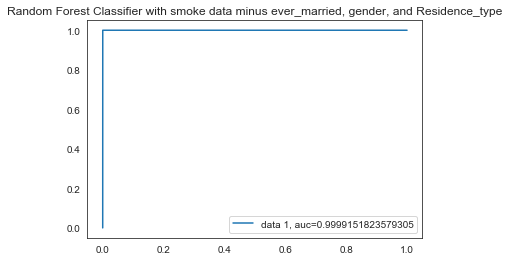


Feature Importance

                   Importance
age                  0.388988
avg_glucose_level    0.271465
bmi                  0.241028
heart_disease        0.039379
smoking_status       0.031321
hypertension         0.027820


In [89]:
mlbl = 'Random Forest Classifier with smoke data minus ever_married, gender, and Residence_type'

df_with_smoke_data_cols_removed_v2 = df_with_smoke_data[[ 'age', 'hypertension', 'heart_disease', 'smoking_status',
                                                      'bmi', 'avg_glucose_level' , 'stroke']]

model_repo[mlbl] = build_model(ran, df_with_smoke_data_cols_removed_v2, mlbl)

With negligable change, it is recommend will continue with this finalized feature selection while completing our final analysis.

Now that we have a well-trained model on the data given, I would like to take it one step further. Let's determine how likely a person may be to be categorized as having a stroke depending on whether or not they were a smoker. To do that, we're going to have to create a synthetic data set that covers a full range of our variables.

Note: If we used the dataset given, we would not have included potential data points that are possible yet not represented in the dataset. Thus, we are using the trained model to create a stroke classification probability distribution for a wide spread range of attributes.

In [90]:
synth_data = []

for age in range(18, 81, 3):
    for s_s in range(0, 3):
        for h_t in range(0, 2):
            for h_d in range(0, 2):
                for bmi in range(5, 110, 5):
                    for a_g in range(40, 301, 10):
                        synth_data.append({'age': age, 'hypertension': h_t, 'heart_disease':h_d, 'bmi':bmi, 
                                           'avg_glucose_level': a_g, 'smoking_status':s_s})
                    
                    
#print(test_synth_data)
synth_df = pd.DataFrame(synth_data)
synth_df

,age,avg_glucose_level,bmi,heart_disease,hypertension,smoking_status
0,18,40,5,0,0,0
1,18,50,5,0,0,0
2,18,60,5,0,0,0
3,18,70,5,0,0,0
4,18,80,5,0,0,0
5,18,90,5,0,0,0
6,18,100,5,0,0,0
7,18,110,5,0,0,0
8,18,120,5,0,0,0
9,18,130,5,0,0,0


In [91]:
synth_df = synth_df[['age', 'hypertension', 'heart_disease', 'smoking_status', 'bmi',
       'avg_glucose_level']]

In [92]:
reduced_ran_model = model_repo['Random Forest Classifier with smoke data minus ever_married, gender, and Residence_type']

In [93]:
#pred = reduced_ran_model.predict(synth_df)
y_pred_proba = reduced_ran_model.predict_proba(synth_df)[:,1]
synth_df['y_pred_proba'] = y_pred_proba

c:\users\wscott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
synth_df

,age,hypertension,heart_disease,smoking_status,bmi,avg_glucose_level,y_pred_proba
0,18,0,0,0,5,40,0.00
1,18,0,0,0,5,50,0.00
2,18,0,0,0,5,60,0.00
3,18,0,0,0,5,70,0.00
4,18,0,0,0,5,80,0.00
5,18,0,0,0,5,90,0.00
6,18,0,0,0,5,100,0.00
7,18,0,0,0,5,110,0.00
8,18,0,0,0,5,120,0.00
9,18,0,0,0,5,130,0.00


In [94]:
#Taking the average probability for people of all ranges with varying smoking status 
never_smoked_stroke_prob = synth_df[synth_df.smoking_status == 1].y_pred_proba.mean()
formerly_smoked_stroke_prob = synth_df[synth_df.smoking_status == 0].y_pred_proba.mean()
smokes_stroke_prob = synth_df[synth_df.smoking_status == 2].y_pred_proba.mean()

print('Never Smoked: {} \nFormerly Smoked: {} \nSmokes: {}'.format("%.2f%%" % (100 * never_smoked_stroke_prob), "%.2f%%" % (100 * formerly_smoked_stroke_prob), 
                                                                       "%.2f%%" % (100 * smokes_stroke_prob)))

Never Smoked: 3.99% 
Formerly Smoked: 5.00% 
Smokes: 5.79%


As you can see, those who have never smoked were 31% less likely to have gotten a stroke compared to those that still smoke to this day. That alone, however, is not a very useful statistic. More importantly is that those who formerly smoked were 14% less likely to have gotten a stroke compared to those that still smoke to this day. 

In other words, if you want to lower your chance of having a stroke, it is worth it to quit smoking. 

_Percentages were calculated using relative change formula:  ((Original - Compared) / Original ))_